In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from read_dataset import build_df
from utils import CFG
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
from models import *
from main import *
from tqdm import tqdm
from torch.utils.data import DataLoader
from datapreprocess import *

import seaborn as sns
from sklearn.metrics import *

# Parameters
params = {"batch_size": 32, "shuffle": True, "num_workers": 4}
max_epochs = 100
NUM_CLASSES = 11
RESNET_OUT_FEATURES = 1000



IMG_FILES = glob(CFG.img_path + "/*.jpg")
XML_FILES = glob(CFG.xml_path + "/*.xml")
df, classes = build_df(XML_FILES)
data = df.to_numpy()

    # input and target
# input and target
input = df[["img_path"]].values
input = np.squeeze(input)
# input = input.reset_index()
target = df[["xmin", "ymin", "xmax", "ymax", "label"]].values.astype(np.int32)


    # splitting data
    # train_data, validation_data, test_data = split_dataset(input,target,True)
train_df, test_df = split_dataset(input, target, validation=False)


In [2]:
train_df

[array(['dataset/data/Paragonimus spp_0745.jpg',
        'dataset/data/Paragonimus spp_0248.jpg',
        'dataset/data/Fasciolopsis buski_0203.jpg', ...,
        'dataset/data/Opisthorchis viverrine_0414.jpg',
        'dataset/data/Hymenolepis diminuta_0160.jpg',
        'dataset/data/Paragonimus spp_0279.jpg'], dtype=object),
 array([[ 484,  380,  799,  579,    8],
        [ 310,  406,  478,  664,    8],
        [1333, 1284, 1757, 2041,    3],
        ...,
        [ 914,  502,  969,  582,    7],
        [1368, 1895, 1701, 2232,    5],
        [1368, 1868, 1750, 2100,    8]], dtype=int32)]

In [3]:
train_df[1][4] # location and label of the fourth item

array([250, 442, 438, 633,   5], dtype=int32)

In [4]:
# train_dataset  = ResNetDataset(train_df, transform=None)
# test_dataset = ResNetDataset(test_df, transform=None)
# train_dataset[0]

In [5]:

transform = preprocess_image
train_dataset  = Custom_Dataset(train_df, transform=transform)
test_dataset = Custom_Dataset(test_df, transform=transform)
# train_dataset[0][1]

In [6]:
# type(test_dataset[0][0])

In [7]:
# plt.imshow(test_dataset[0][0].permute(1,2,0))

In [8]:

# Dataloaders
train_dataloader = DataLoader(
    train_dataset, params["batch_size"], num_workers=params["num_workers"], shuffle=params["shuffle"],
)
# validation_dataloader = torch.utils.data.DataLoader(validation_data, params['batch_size'],num_workers=params['num_workers'])
test_dataloader = DataLoader(
    test_dataset, params["batch_size"], num_workers=params["num_workers"]
)


In [9]:

def get_default_device():
    """gets gpu for mac m1 or cuda, or cpu machine"""
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('Running on Cuda GPU')
        return device
        # x = torch.ones(1, device=mps_device)
        # print(x)
        
    
    elif torch.backends.mps.is_available():
        print('Running on the Mac GPU')
        mps_device = torch.device("mps")
        return mps_device
        
    else:
        # print("MPS device not found.")
        return torch.device('cpu')
        print('Code Running on a CPU')

In [10]:

def train_model(train_dataloader, loss_fn,in_channels=1000,num_classes=11, epochs=30, learning_rate=0.001, device=None):
    
    if device is None:
        device = 'cpu'
    model = get_custom_model(res_out_features=in_channels, n_classes=num_classes).to(device)

    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=learning_rate)

    training_losses = []
    training_accs = []

    for epoch in range(1, epochs+1):
        number_of_batches = 0
        epoch_loss_values = 0.0
        epoch_accs = 0.0
        for index, batch in enumerate(tqdm(train_dataloader)):
            # X,  y = X.to(device), y.to(device)  # make the tensors in gpu state
            X   = batch[0]
            y = batch[1]
            X  = Variable(X, requires_grad=True).to(device)
            y  = torch.LongTensor(y).to(device)

            preds = model(X)

            loss = loss_fn(preds, y).to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            probs = torch.log_softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)

            # acc
            epoch_accs += accuracy_score(y.detach().cpu(),
                                         predicted_labels.detach().cpu())
            epoch_loss_values += loss.item()

            number_of_batches += 1

        # compute average of batch loss and accuracy
        batch_acc, batch_loss = epoch_accs / \
            number_of_batches, epoch_loss_values / number_of_batches
        training_losses.append(batch_loss)
        training_accs.append(batch_acc)

        print("Epoch:{}/{}, acc={:.3f}%, loss={:.3f}".format(epoch,
              epochs, batch_acc*100, batch_loss))

    print("Learning Finished!")

    return model, training_accs, training_losses



In [11]:
DEVICE = get_default_device()

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
input_features = RESNET_OUT_FEATURES
EPOCHS = 20

Running on Cuda GPU


In [12]:
DEVICE

device(type='cuda')

In [13]:
# trained_model,training_accs, training_losses =  train_model(train_dataloader, loss_fn, input_features, num_classes = NUM_CLASSES, epochs=EPOCHS, learning_rate=learning_rate,device=DEVICE)

In [14]:
import matplotlib.pyplot as plt

def plot_model_history(training_accs, training_losses):# Get training and test loss histories

    # Create count of the number of epochs
    epoch_count = range(1, len(training_accs) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_losses, 'r--')
    plt.plot(epoch_count, training_accs, 'b-')
    plt.legend(['Training Loss', 'Training Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy and Loss Curves')
    plt.show()

In [15]:
# testing/ validation of unet model
def validate_model(trained_model, test_dataloader, device=None):
    trained_model.eval() # switch off some layers such as dropout layer during validation
    with torch.no_grad():
        test_predictions = []
        test_labels = []

        for i, (x, y) in enumerate(test_dataloader):
            x  = x.to(device)
            y  = y.to(device)
            y_hat = trained_model(x)
            predicted_labels =  torch.argmax(y_hat, dim=1).detach().cpu().numpy().tolist()
            # y_hat  = y_hat.cpu()
            y = y.detach().cpu().numpy().tolist()
            test_predictions.extend(predicted_labels)
            test_labels.extend(y)
    
        return test_labels, test_predictions

In [16]:
def evalution_metrics(ground_truth, predictions):
    print(f"mean acc score = {accuracy_score(ground_truth, predictions)}")
    print(f"mean recall score = {recall_score(ground_truth, predictions, average='micro')}")
    print(f"precision score = {precision_score(ground_truth, predictions, average='micro')}")
    print(f"mean f1 score = {f1_score(ground_truth, predictions, average='micro')}")
    labels = np.unique(ground_truth).tolist()
    cm  = confusion_matrix(ground_truth, predictions, labels=labels) 
    report  = classification_report(ground_truth, predictions)
    print(report)

    sns.heatmap(cm)
    plt.show()


In [17]:
# test_labels, test_predictions = validate_model(trained_model, test_dataloader, device=DEVICE)

In [18]:
# evalution_metrics(test_labels, test_predictions)

In [19]:
def save_model(model, path=None):
    if path is not None:
        torch.save(model.state_dict(), path)
    else:
        curr_dir  = os.getcwd()
        torch.save(model.state_dict(), curr_dir)


# def load_model(model_weights, path):

#     model = NeuralNet()
#     model.load_state_dict(torch.load(path))
#     model.eval()

#     return model
    

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, input_channels=3, filters=32, num_classes=11):
        super(CNN, self).__init__()
        self.conv1  = nn.Conv2d(input_channels, filters, kernel_size=2) 
        self.conv2  = nn.Conv2d(filters, filters * 2, kernel_size=3)
        self.conv3 = nn.Conv2d(filters * 2, filters * 4, kernel_size=3)

        self.fc1  =  nn.Linear(in_features=  (filters * 4 * 28*28  + 1_000) , out_features=64)
        self.out = nn.Linear(64, out_features=num_classes)

        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x, x2):
        x  = self.conv1(x) # output = (B, C,224,224)
        x  = F.relu(x) 
        x  = F.max_pool2d(x, kernel_size=2, padding=1) #output = (B,C,112,112)
        x  = F.dropout(x, 0.2)

        x  = self.conv2(x) #output = (B,iC,112,112)
        x  = F.relu(x)
        x  = F.max_pool2d(x, kernel_size=2, padding=1) # #output = (B,iC,56,56)
        x  = F.dropout(x, 0.2)
        x  = self.conv3(x)
        x  = F.relu(x)
        x  = F.max_pool2d(x, kernel_size=2, padding=1) # output = (B, iC, 28 , 28)
        x  = F.dropout(x, 0.2)
        x  = self.flatten(x)
        # print("x2 size = ", x2.size())
        # print(
        #     'size of x  = ', x.size(),
        # )
        x  = torch.cat((x, x2), dim=1)
        print("cat size = ", x.size())
        x  = self.fc1(x)
        x  = F.relu(x)
        x  = F.dropout(x, 0.25)
        x  = self.out(x)
        return x

In [21]:
cnn_model = CNN(3,32,11)
test_data  = torch.randn(size = (10, 3, 224,224))

In [22]:
from torchsummary import summary
# summary(cnn_model, (test_data, torch.tensor(torch.randn(10, 1000))))

In [23]:
import torchvision




In [24]:
def get_pretrained_model():
    
    resnet152 = torchvision.models.resnet152(pretrained=True)
    resnet152.eval()
    # remove the last layer
    # new_model = torch.nn.Sequential(*(list(resnet152.children())[:-1]))
    # freeze the model
    for param in resnet152.parameters():
        param.requires_grad = False

    # if device is not None:
    #     resnet152.to(device)

    return resnet152


In [25]:
def resnet_preprocess(X):
    return X

In [26]:

def trainCustomModel(resnetModel,yoloDetectModel,customCNNModel, train_dataloader,optimizer,loss_fn,in_channels=3,num_classes=11, epochs=30, learning_rate=0.001, device='cpu'):
    """Accepts feature from resnet 
    and yolo object detection cropped iamge(s) 
    as features to train an accurate cnn classifier.
    """

    training_losses = []
    training_accs = []

    for epoch in range(1, epochs+1):
        number_of_batches = 0
        epoch_loss_values = 0.0
        epoch_accs = 0.0
        for index, batch in enumerate(tqdm(train_dataloader)):
            # X,  y = X.to(device), y.to(device)  # make the tensors in gpu state
            X   = batch[0]
            y = batch[1]
            X  = Variable(X, requires_grad=True).to(device)
            y  = torch.LongTensor(y).to(device)

            # resnet processing
            # resnet_X = Variable(resnet_preprocess((X.cpu())), requires_grad=True).to(device)
            resnet_X  = resnetModel(X)

            # extracted_features = resnetModel(resnet_X) # (Bacth, 1000) tensor is returned
            # X2  = Variable(torch.randn(size= (X.size()[0],1000)), requires_grad=True).to(device)
            preds = customCNNModel(X, resnet_X)
        

            loss = loss_fn(preds, y).to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            probs = torch.log_softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)

            # acc
            epoch_accs += accuracy_score(y.detach().cpu(),
                                         predicted_labels.detach().cpu())
            epoch_loss_values += loss.item()

            number_of_batches += 1

        # compute average of batch loss and accuracy
        batch_acc, batch_loss = epoch_accs / \
            number_of_batches, epoch_loss_values / number_of_batches
        training_losses.append(batch_loss)
        training_accs.append(batch_acc)

        print("Epoch:{}/{}, acc={:.3f}%, loss={:.3f}".format(epoch,
              epochs, batch_acc*100, batch_loss))

    print("Learning Finished!")

    return training_accs, training_losses

In [27]:
customCNNModel = CNN(input_channels=3, filters=16, num_classes=11).to(DEVICE) 
optimizer = torch.optim.Adam(
        params=customCNNModel.parameters(), lr=learning_rate)

In [34]:
resnetModel  = get_pretrained_model().to(DEVICE)
# res_out_features = resnetModel(test_data.to(DEVICE))
# res_out_features.shape

In [35]:
print(DEVICE)
from torch.utils.data import Dataset

cuda


In [36]:
testy  = torch.randint(1, 4, size =(10,))
testy

tensor([1, 3, 2, 3, 1, 2, 3, 3, 2, 3])

In [38]:
dummy_dataset  = TinyDataset((test_data, testy))
dummy_dataloader =  DataLoader(dummy_dataset, batch_size = 2, shuffle=True)

In [39]:
training_accs, training_losses = trainCustomModel(resnetModel, None,customCNNModel, train_dataloader, optimizer,loss_fn, in_channels=3,num_classes=11, epochs=2, learning_rate=0.001, device=DEVICE)

  0%|          | 0/274 [00:09<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 10.76 GiB total capacity; 6.15 GiB already allocated; 27.88 MiB free; 6.41 GiB reserved in total by PyTorch)

In [ ]:
# x2  = torch.randn(10, 1000)
# summary(customCNNModel, (test_data, x2))

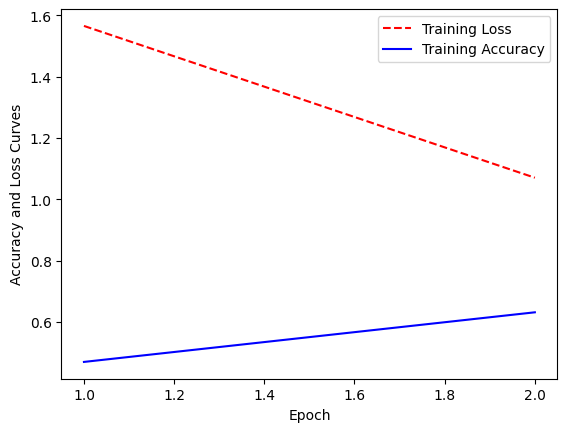

In [ ]:
plot_model_history(training_accs, training_losses)

In [ ]:
path = os.path.join(os.getcwd(),'model_weights.pth')

In [ ]:
torch.save(customCNNModel.state_dict(), path)

In [ ]:
# customCNNModel.state_dict()

In [ ]:
# loaded_model.state_dict()

# model = CNN(3, 32, NUM_CLASSES).to(DEVICE)
# model.load_state_dict(torch.load(path))
# model.eval()

In [ ]:
# model.state_dict()


In [ ]:

# validate_model(model, test_dataloader)
